# Tutorial 1 - Photonic tensor core
<figure>
<img src="./schematic.png" alt="Description" width="500">
<figcaption>This is an example caption.</figcaption>
</figure>

Meshes of optical waveguides can be used to perform unitary matrix operations on a set of optical modes. Photonic tensor cores are analog computing systems that aim to exploit this for accelerating the computation of linear algebra operations in various use cases. This tutorial shows how to create a simple photonic tensor core based on Clements meshes in BYOD. This notebook shows how to generate an SST configuration file that assembles the photonic system and connects it to a DDR4 memory system simulated with [DRAMsim3](https://github.com/umd-memsys/DRAMsim3). Using the configuration file, SST performs an end-to-end simulation of loading data from memory, performing a set of subsequent matrix-vector computations and storing the results back in memory. The simulation outputs the system's throughput and energy consumption.

The configuration file is built up in 4 consecutive steps:
1. [Simulating a controller and memory system](#Step-1:-Simulating-a-controller-and-memory-system)
2. [Simulating a photonic link](#Step-2:-Simulating-a-photonic-link)
3. [Simulating a photonic tensor core](#step-3-simulating-a-photonic-tensor-core)
4. [Analyzing throughput of the photonic tensor core](#step-4-analyzing-the-throughput-of-the-tensor-core-as-a-function-of-the-clock-frequency)

## Step 1: Simulating a controller and memory system 

The simulation consists of a basic streaming CPU and a DDR4 memory. The streaming CPU will read a chunk of memory defined by the user, order the received data into vectors of a defined size and bit resolution and stream them to its data output port. The output is looped back into the CPU's data input port, where data is buffered and written back to the memory. The simulation will end once all data has been written back to the memory.

The simulation can be set up and executed with the following configuration script:

In [320]:
%%writefile sst_config_no1.py

import os
FILE_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append(os.path.join(FILE_DIR,'../../utils'))
from clements_utils import *
sys.path.append(FILE_DIR)
import sys
import sst
import numpy as np

# --- Set the simulation parameters ---

clock = 1.0 #clock frequency in GHz
clock = str(clock) +f"Ghz"
size = 8 #size of the data vector
resolution = 8 #bit resolution of the data
data_size = 10 #number of data points

DEBUG_LEVEL = 0 #select the level of debuggin output, 0 disables component outputs, 1 shows detailed timestampts
STATISTICSPATH = os.path.abspath(os.path.join(FILE_DIR, "output/sim_output.csv")) #output files for the energy simulations
STATISTICSPATH_DRAM = os.path.abspath(os.path.join(FILE_DIR, "output")) #output folder for the DRAM energy simulations
DRAM_CONFIG = os.path.abspath(os.path.join(FILE_DIR,'../../utils/DRAM_configs/LPDDR4_8Gb_x16_2400.ini')) #config file for a LPDDR4 memory

# --- Generate the test data to be read from memory ---

test_data = np.random.uniform(0, pow(2,resolution), size * data_size).astype(int)
print('Test data vectors: \n', test_data.reshape(data_size, size))
data_bytes = voltages_to_bytes(test_data, resolution) #Convert data into bytes to create the memory image

# --- Set up the CPU ---

cpu = sst.Component("cpu", "byod.StreamingCPU")
cpu.addParams({
    "memory": np.array(data_bytes).flatten().tolist(),
    "size": size,
    "resolution": resolution,
    "frequency": clock,
    "vector_count": len(test_data) / size,
    "verbose": DEBUG_LEVEL
})

iface = cpu.setSubComponent("memory", "memHierarchy.standardInterface")
iface.enableAllStatistics()

# --- Set up the memory ---

#Define a memory controller running at half the clock frequency of the memory
memctrl = sst.Component("memory", "memHierarchy.MemController")
memctrl.addParams({
        "debug": 0,
        "debug_level": 0,
        "clock": f"1.2GHz",
        "addr_range_end": 1024 * 1024 * 1024 - 1,
})

#Connect the memory controller with the DRAMSim3 simulator for a DDR4 memory
memory = memctrl.setSubComponent("backend", "memHierarchy.dramsim3")
memory.enableAllStatistics()
memory.addParams({
    "mem_size": "1GiB",
    "config_ini" : DRAM_CONFIG,
    "output_dir": STATISTICSPATH_DRAM
})

# --- Connect the components with links ---

#link CPU and memory
link_cpu_memory_link = sst.Link("link_cpu_cache_link")
link_cpu_memory_link.connect( (iface, "lowlink", "1ps"), (memctrl, "highlink", "1ps") )

#link CPU output and input for the callback loop
link_cpu_callback = sst.Link("link_cpu_callback")
link_cpu_callback.connect( (cpu, "outputData", "1ps"), (cpu, "input", "1ps") )

# --- Configure the simulation output file ---

sst.setStatisticLoadLevel(7)
sst.setStatisticOutput("sst.statOutputCSV", {"filepath": STATISTICSPATH, "separator": ","})

Writing sst_config_no1.py


Execute the cell above to generate the simulation configuration file \"sst_config.py\" in the tutorial folder. To run the simulation, move into the tutorial folder and execute the following command in the command prompt to start the simulation:
```bash
$ sst sst_config.py
```
If successful, the simulation should produce something similar to the following output:
```bash
Test data vectors: 
 [[177  84  24 210 114 240 208 177  29 102]
 [201 225  54  75  99 230 182  65  15  58]
 [246 210  42 177 254  59 249  83  25 128]
 [182 133  25 246 178  20 218 184  10 228]
 [ 27 205  71 150  21 251  96 189 251  73]
 [103 108  29 179 135 233 192 191 236 214]
 [173 147  18  85  81 200  25   1  33  43]
 [ 21 231  64   6 152  43 206 107  91  17]]
Data in: {177,  84,  24, 210, 114, 240, 208, 177} 0  9
Data in: { 29, 102, 201, 225,  54,  75,  99, 230} 1  9
Data in: {182,  65,  15,  58, 246, 210,  42, 177} 2  9
Data in: {254,  59, 249,  83,  25, 128, 182, 133} 3  9
Data in: { 25, 246, 178,  20, 218, 184,  10, 228} 4  9
Data in: { 27, 205,  71, 150,  21, 251,  96, 189} 5  9
Data in: {251,  73, 103, 108,  29, 179, 135, 233} 6  9
Data in: {192, 191, 236, 214, 173, 147,  18,  85} 7  9
Data in: { 81, 200,  25,   1,  33,  43,  21, 231} 8  9
Data in: { 64,   6, 152,  43, 206, 107,  91,  17} 9  9
Simulation is complete, simulated time: 45.001 ns
```
The output shows the 10 randomly generated test vectors and the data written back from the CPU to the memory. From the output, we can confirm that the data has been read and processed correctly. The simulation also reveals that the entire operation takes 53ns to complete. You can try changing the simulation parameters (e.g., resolution, clock frequency) and observe how this affects the simulation time.

The memory simulation also computes the activation statistics and the energy consumption. The results are stored in \"output/dramsim3.txt\". Execute the cell below to show the total energy consumed (in pJ) by the DDR4 memory:

In [221]:
import json

with open('output/dramsim3.json', 'r') as file:
    data = json.load(file)
mem_energy = float(data['0']['total_energy'])
print('Energy consumed by memory in pJ: ', mem_energy)

Energy consumed by memory in pJ:  44304.0


## Step 2: Simulating a photonic link

This is a simulation of a photonic link for transmitting data via an amplitude-modulated optical signal. Based on the previous example, the output of the streaming CPU is connected to an array of digital-analog-converters (DACs) that convert the data into analog voltage signals. The signals drives an array of optical modulators that encode the analog signals in the amplitude of a set of optical signals. The signals are detected by a photodetector, whose output voltages are converted back to digital signals using an array of analog-digital-converters (ADCs). The signals are fed back to the input port of the CPU. The simulation will end once all data has been written back to the memory

The simulation can be set up and executed with the following configuration script:

In [342]:
%%writefile sst_config_no2.py

import os
import sys
FILE_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append(os.path.join(FILE_DIR,'../../utils'))
from clements_utils import *
from byod_components import StreamingCPU, ADC, DAC, Modulator
sys.path.append(FILE_DIR)
import sst
import numpy as np

# --- Set the simulation parameters ---

clock = 1.0 #clock frequency in GHz
clock = str(clock) +f"Ghz"
size = 8 #size of the input data vector
resolution = 8 #bit resolution of the data
data_size = 10 #number of data points
P_pi = 1E-3 #power for a pi phase shift
R = 1000 #resistance of the heater in Ohms
vmax = np.sqrt(P_pi * 2 * R) #voltage to achieve a 2pi phase shift

DEBUG_LEVEL = 0
STATISTICSPATH = os.path.abspath(os.path.join(FILE_DIR, "output/sim_output.csv"))
STATISTICSPATH_DRAM = os.path.abspath(os.path.join(FILE_DIR, "output"))
DRAM_CONFIG = os.path.abspath(os.path.join(FILE_DIR,'../../utils/DRAM_configs/LPDDR4_8Gb_x16_2400.ini'))

# --- Set up helper functions for each component (energy models, data pre-processing, ...) ---

cpu_helper = StreamingCPU(resolution = resolution)
adc_helper = ADC(resolution = resolution)
dac_helper = DAC(resolution = resolution, maxVin = vmax)
mod_helper = Modulator(R = R, pPi = P_pi)

# --- Generate the test data to be read from memory ---

test_data = np.random.uniform(0, 1, size * data_size)
voltages_data = mod_helper.getVoltagesFromAmplitudes(np.sqrt(test_data))
adlevels_data = dac_helper.getLevelsFromVoltages(voltages_data)
data_bytes = cpu_helper.getBytesFromLevels(adlevels_data)

print('Data vector: \n', voltages_to_AD_levels(test_data, resolution, vmax).reshape((data_size, size)))

# --- Set up the CPU ---

cpu = sst.Component("cpu", "byod.StreamingCPU")
cpu.addParams({
    "memory": np.array(data_bytes).flatten().tolist(),
    "size": size,
    "resolution": resolution,
    "frequency": clock,
    "vector_count": len(test_data) / size,
    "verbose": DEBUG_LEVEL
})

iface = cpu.setSubComponent("memory", "memHierarchy.standardInterface")
iface.enableAllStatistics()

# --- Set up the memory ---

memctrl = sst.Component("memory", "memHierarchy.MemController")
memctrl.addParams({
        "debug": 0,
        "debug_level": 0,
        "clock": f"1.2GHz",
        "addr_range_end": 1024 * 1024 * 1024 - 1,
})

memory = memctrl.setSubComponent("backend", "memHierarchy.dramsim3")
memory.enableAllStatistics()
memory.addParams({
    "mem_size": "1GiB",
    "config_ini" : DRAM_CONFIG,
    "output_dir": STATISTICSPATH_DRAM
})

# --- Set up the DAC array ---

dac_data = sst.Component("dac_data", "byod.DAC")
dac_data.enableAllStatistics()
dac_data.addParams({
    "size": size,
    "maxVout": vmax,
	"resolution": resolution,
	"frequency": clock,
    "dacType": "R2R",
    "verbose": DEBUG_LEVEL,
})

# --- Set up the optical modulator array ---

mod = sst.Component("mod", "byod.AmplitudeModulator")
mod.enableAllStatistics()
mod.addParams({
    "size": size,
    "laserPower": 0.005,
    "laserWpe": 0.5,
    "verbose": DEBUG_LEVEL,
})

# --- Select and set up thermo-optic modulators for the modulator array ---

ampMod = mod.setSubComponent("modulator", "byod.thermoOpticModulator")
ampMod.addParams({
    "resistance": R,
    "p_pi": P_pi
})

# --- Set up the photodetector array ---

pd = sst.Component("pd", "byod.Photodetector")
pd.enableAllStatistics()
pd.addParams({
    "size": size,
    "tiaGain": 1/(0.005),
    "verbose": DEBUG_LEVEL,
})

# --- Set up the ADC array ---

adc_data = sst.Component("adc_data", "byod.ADC")
adc_data.enableAllStatistics()
adc_data.addParams({
    "size": size,
    "maxVin": vmax,
	"resolution": resolution,
	"frequency": clock,
    "conversionEnergy": "2.66",
    "latency": 100,
    "verbose": DEBUG_LEVEL
})

# --- Connect the components with links ---

link_cpu_memory_link = sst.Link("cpu_memory")
link_cpu_memory_link.connect( (iface, "lowlink", "1ps"), (memctrl, "highlink", "1ps") )

link_cpu_dac = sst.Link("cpu_dac")
link_cpu_dac.connect( (cpu, "outputData", "1ps"), (dac_data, "input", "1ps"))

link_dac_mod = sst.Link("dac_mod")
link_dac_mod.connect( (dac_data, "output", "1ps"), (mod, "input", "1ps"))

link_mod_pd = sst.Link("mod_pd")
link_mod_pd.connect( (mod, "output", "10ps"), (pd, "input", "10ps"))

link_pd_adc = sst.Link("pd_adc")
link_pd_adc.connect( (pd, "output", "1ps"), (adc_data, "input", "1ps"))

link_adc_cpu = sst.Link("adc_cpu")
link_adc_cpu.connect( (adc_data, "output", "1ps"), (cpu, "input", "1ps"))

# --- Configure the simulation output file ---

sst.setStatisticLoadLevel(7)
sst.setStatisticOutput("sst.statOutputCSV", {"filepath": STATISTICSPATH, "separator": ","})

Overwriting sst_config_no2.py


Execute the cell above to generate the simulation configuration file \"sst_config_no2.py\" in the tutorial folder. To run the simulation, move into the tutorial folder and execute the following command in the command prompt to start the simulation:
```bash
$ sst sst_config_no2.py
```
The simulation will output the original test data and the data received by the CPU, similar to this:
```bash
Data vector: 
 [[ 69 106 171  98  61   9  11  86]
 [ 46  30  48  44  56  79  88 111]
 [143  69 140  14  14  94 161 136]
 [ 47 153  26  51  53  24 176  30]
 [ 81 160 150  22  88  19  18 155]
 [172 166 150 115  89  33  54 120]
 [ 27 151 178  61 162  74 176 174]
 [ 77  21  48  82 141 121  94  18]
 [175  66 178  71 130 150  21 114]
 [ 39  94  89 177  36 117  15  49]]
Data in: { 71, 108, 171,  99,  61,  10,  12,  87} 0  9
Data in: { 48,  30,  48,  45,  58,  81,  90, 111} 1  9
Data in: {144,  71, 140,  15,  15,  96, 161, 136} 2  9
Data in: { 48, 153,  27,  54,  54,  24, 176,  33} 3  9
Data in: { 84, 161, 151,  22,  90,  19,  19, 156} 4  9
Data in: {172, 167, 151, 117,  90,  36,  54, 122} 5  9
Data in: { 30, 151, 178,  64, 163,  74, 176, 175} 6  9
Data in: { 81,  22,  48,  84, 142, 122,  96,  19} 7  9
Data in: {175,  68, 178,  74, 132, 150,  22, 117} 8  9
Data in: { 42,  96,  90, 178,  39, 119,  17,  51} 9  9
```
Note the small differences, which occur due to the quantization of the data and the nonlinearity by the optical modulator.
The simulation will also compute the activation statistics and the energy consumption of all components. The results are stored in \"output/dramsim3.txt\" and in \"output/sim_output.csv\". Execute the cell below to show 
+ Total runtime in ns
+ Throughput in MSamples/s
+ Energy consumption in nJ
+ Average power consumption in W

This will also plot a relative breakdown of the energy consumed by all individual components.

Runtime in ns:  47.101
Throughput in MOps/s:  212.30971741576613
Total energy in nJ:  50.39657507800001
Average power in Watts:  1.0699682613532622


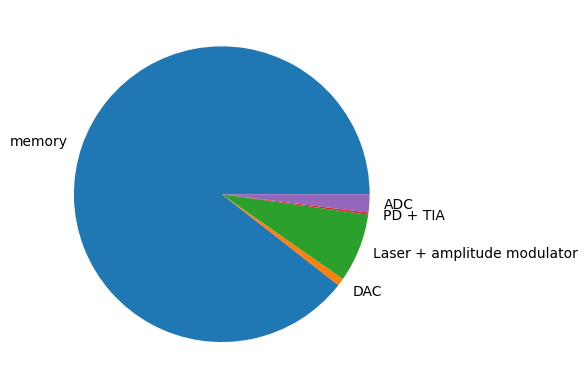

In [331]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open('output/dramsim3.json', 'r') as file:
    data = json.load(file)
mem_energy = float(data['0']['total_energy'])

data = np.loadtxt('output/sim_output.csv', delimiter = ',', dtype = 'str')

runtime = float(data[1][4]) / 1000
dac_data_energy = float(data[1][6])
modulator_energy = float(data[2][6])
pd_energy = float(data[3][6])
adc_energy = float(data[4][6])
total_energy = np.array([mem_energy, dac_data_energy, modulator_energy, pd_energy, adc_energy])
energy_labels = ['memory', 'DAC', 'Laser + amplitude modulator', 'PD + TIA', 'ADC']
print('Runtime in ns: ', runtime)
print('Throughput in MOps/s: ', 10/(runtime *1E-3))
print('Total energy in nJ: ', np.sum(total_energy)*1E-3)
print('Average power in Watts: ', np.sum(total_energy)/runtime / 1000)
plt.pie(total_energy, labels = energy_labels)
plt.savefig('output/example2_energy_breakdown.png', dpi=300)
plt.show()

## Step 3: Simulating a photonic tensor core

This is a simulation of a photonic tensor core. Based on the previous example, the CPU streams data from the memory to its output port. The data is converted to an optical signal, which passes through an optical mesh before being detected by an array of photodiodes. The mesh perform a matrix-vector multiplication on the input signals. Finally, the signal is converted back to a digital signal, send to the CPU, which writes it to the memory. The simulation will end once all data has been written back to the memory.

The simualtion can be set up and exectured with the following configuration script:

In [ ]:
%%writefile sst_config_no3.py

import os
FILE_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append(os.path.join(FILE_DIR,'../../utils'))
from byod_components import StreamingCPU, ADC, DAC, Modulator, ClementsMesh
sys.path.append(FILE_DIR)
import sys
import sst
import numpy as np
from argparse import ArgumentParser

# --- Set the simulation parameters ---

parser = ArgumentParser()
parser.add_argument("-clock", type=float,
                    help="set the clock frequency in GHz", default = 1.0) #clock frequency can be set as command line argument when running the SST simulation
args = parser.parse_args()
clock = str(args.clock) +f"Ghz"
size = 8 #size of the data vector
resolution = 8 #bit resolution of the data
data_size = 50 #number of data points
P_pi = 1E-3 #power for a pi phase shift
R = 1000 #resistance of the heater in Ohms
vmax = np.sqrt(P_pi * 2 * R) #voltage to achieve a 2pi phase shift

DEBUG_LEVEL = 0
STATISTICSPATH = os.path.abspath(os.path.join(FILE_DIR, "output/sim_output.csv"))
STATISTICSPATH_DRAM = os.path.abspath(os.path.join(FILE_DIR, "output"))
DRAM_CONFIG = os.path.abspath(os.path.join(FILE_DIR,'../../utils/DRAM_configs/LPDDR4_8Gb_x16_2400.ini'))

# --- Set up helper functions for each component (energy models, data pre-processing, ...) ---

cpu_helper = StreamingCPU(resolution = resolution)
adc_helper = ADC(resolution = resolution)
dac_helper = DAC(resolution = resolution, maxVin = vmax)
clementsMesh = ClementsMesh(size = size, pPi = P_pi, R = R)
mod_helper = Modulator(R = R, pPi = P_pi)

# --- Generate the test data and test matrix. Decompose the matrix into unitary matrices (U,S,V) using SVD decomposition ---

test_matrix = np.random.uniform(0, 1, (size,size))
test_data = np.random.uniform(0, 1, size * data_size)
U, S, V = np.linalg.svd(test_matrix)
scale_s = np.max(S)
S = S / scale_s
U = U
V = V

# --- Compute voltages to program the Clements meshes ---

clementsMesh.decompose(U)
voltages_u = clementsMesh.voltages
clementsMesh.decompose(V)
voltages_v = clementsMesh.voltages
voltages_s = mod_helper.getVoltagesFromAmplitudes(S)
voltages_data = mod_helper.getVoltagesFromAmplitudes(test_data)

# --- Compute corresponding DAC levels ---

adlevels_u = dac_helper.getLevelsFromVoltages(voltages_u)
adlevels_s = dac_helper.getLevelsFromVoltages(voltages_s)
adlevels_v = dac_helper.getLevelsFromVoltages(voltages_v)
adlevels_data = dac_helper.getLevelsFromVoltages(voltages_data)

# --- Generate memory image ---

weight_bytes = np.zeros(0)
weight_bytes = np.append(weight_bytes, cpu_helper.getBytesFromLevels(adlevels_u))
weight_bytes = np.append(weight_bytes, cpu_helper.getBytesFromLevels(adlevels_s))
weight_bytes = np.append(weight_bytes, cpu_helper.getBytesFromLevels(adlevels_v))

data_bytes = cpu_helper.getBytesFromLevels(adlevels_data)

# --- Set up the CPU ---

cpu = sst.Component("test", "byod.StreamingCPU")
cpu.addParams({
    "memory": (np.append(weight_bytes, data_bytes)).tolist(),
    "weight_address": (np.array([0, len(weight_bytes), len(weight_bytes) / np.ceil(resolution/8), resolution]).flatten()).tolist(),
    "vector_base_addr": len(weight_bytes),
    "size": size,
    "resolution": resolution,
    "frequency": clock,
    "vector_count": len(test_data) / size,
    "verbose": DEBUG_LEVEL,
})

iface = cpu.setSubComponent("memory", "memHierarchy.standardInterface")
iface.enableAllStatistics()

# --- Set up the memory ---

memctrl = sst.Component("memory", "memHierarchy.MemController")
memctrl.addParams({
        "debug": 0,
        "debug_level": 0,
        "clock": f"1.2GHz",
        "addr_range_end": 1024 * 1024 * 1024 - 1,
})

memory = memctrl.setSubComponent("backend", "memHierarchy.dramsim3")
memory.enableAllStatistics()
memory.addParams({
    "mem_size": "1GiB",
    "config_ini" : DRAM_CONFIG,
    "output_dir": STATISTICSPATH_DRAM,
})

# --- Set up the DAC connecting the CPU to the optical modulator for feeding in data ---

dac_data = sst.Component("dac_data", "byod.DAC")
dac_data.enableAllStatistics()
dac_data.addParams({
    "size": size,
    "maxVout": vmax,
	"resolution": resolution,
	"frequency": clock,
    "dacType": "R2R",
    "verbose": DEBUG_LEVEL,
})

# --- Set up the DAC connecting the CPU to the mesh modulators for programming the weight matrix ---

dac_weight = sst.Component("dac_weight", "byod.DAC")
dac_weight.enableAllStatistics()
dac_weight.addParams({
    "size": (2 * size * size + size),
    "maxVout": vmax,
	"resolution": resolution,
	"frequency": clock,
    "dacType": "R2R",
    "verbose": DEBUG_LEVEL,
})

# --- Set up the optical modulator array ---

mod = sst.Component("mod", "byod.AmplitudeModulator")
mod.enableAllStatistics()
mod.addParams({
    "size": size,
    "laserPower": 0.005,
    "laserWpe": 0.5,
    "verbose": DEBUG_LEVEL,
})

# --- Select and set up thermo-optic modulators for the modulator array ---

ampMod = mod.setSubComponent("modulator", "byod.thermoOpticModulator")
ampMod.addParams({
    "resistance": R,
    "p_pi": P_pi
})

# --- Set up the optical mesh for performing a matrix-vector multiplication on the input data ---

mesh = sst.Component("mesh", "byod.ClementsSVD")
mesh.enableAllStatistics()
mesh.addParams({
    "size": size,
    "opticalLoss": 0.0,
    "verbose": DEBUG_LEVEL,
})

mesh_mod = mesh.setSubComponent("modulator", "byod.thermoOpticModulator")
mesh_mod.addParams({
    "resistance": R,
    "p_pi": P_pi,
})
mesh_mod.enableAllStatistics()

# --- Set up the photodetector detecting the output of the optical mesh ---

pd = sst.Component("pd", "byod.Photodetector")
pd.enableAllStatistics()
pd.addParams({
    "size": size,
    "tiaGain": 100,
    "verbose": DEBUG_LEVEL,
})

# --- Setup the ADC connecting the photodetector the CPU input ---

adc_data = sst.Component("adc_data", "byod.ADC")
adc_data.enableAllStatistics()
adc_data.addParams({
    "size": size,
    "maxVin": vmax,
	"resolution": resolution,
	"frequency": clock,
    "conversionEnergy": "2.66",
    "latency": 100,
    "verbose": DEBUG_LEVEL,
})

# --- Connect the components with links ---

link_cpu_memory_link = sst.Link("link_cpu_memory_link")
link_cpu_memory_link.connect( (iface, "lowlink", "10ps"), (memctrl, "highlink", "10ps") )

link_cpu_dac = sst.Link("cpu_dac")
link_cpu_dac.connect( (cpu, "outputData", "10ps"), (dac_data, "input", "10ps"))

link_cpu_dacweight = sst.Link("cpu_dacweight")
link_cpu_dacweight.connect( (cpu, "outputWeight0", "10ps"), (dac_weight, "input", "10ps"))

link_dac_mod = sst.Link("dac_mod")
link_dac_mod.connect( (dac_data, "output", "10ps"), (mod, "input", "10ps"))

link_dacweight_mesh = sst.Link("dacweight_mesh")
link_dacweight_mesh.connect( (dac_weight, "output", "10ps"), (mesh, "inputWeight", "10ps"))

link_mod_mesh = sst.Link("mod_mesh")
link_mod_mesh.connect( (mod, "output", "10ps"), (mesh, "inputData", "10ps"))

link_mesh_pd = sst.Link("mesh_pd")
link_mesh_pd.connect( (mesh, "output", "10ps"), (pd, "input", "10ps"))

link_pd_adc = sst.Link("pd_adc")
link_pd_adc.connect( (pd, "output", "10ps"), (adc_data, "input", "10ps"))

link_adc_cpu = sst.Link("adc_cpu")
link_adc_cpu.connect( (adc_data, "output", "10ps"), (cpu, "input", "10ps"))

# --- Set the output for the energy statistics ---

sst.setStatisticLoadLevel(7)
sst.setStatisticOutput("sst.statOutputCSV", {"filepath": STATISTICSPATH, "separator": ","})

Overwriting sst_config_no3.py


Execute the cell above to generate the configuration files \"sst_config_no3.py\" in the tutorial filder. Run the simulation as before with the ```sst``` command. 

The simulation will compute the activation statistics and the energy consumption of all components. The results are stored in \"output/dramsim3.txt\" and in \"output/sim_output.csv\". Execute the cell below to show 
+ Total runtime in ns
+ Throughput in MSamples/s
+ Energy consumption in nJ
+ Average power consumption in W

This will also plot a relative breakdown of the energy consumed by all individual components:

Runtime in ns:  87.11
Throughput in MOps/s:  573.9869130983814
Total energy in nJ:  132.835834137
Average power in Watts:  1.5249206077029043


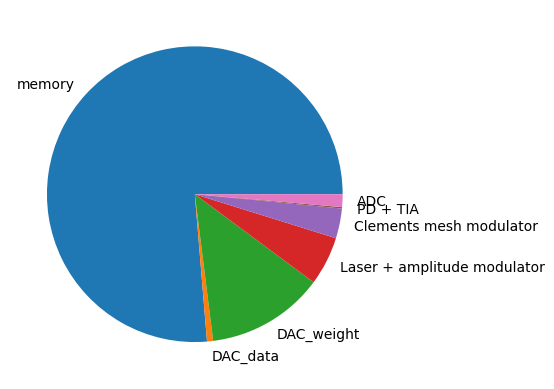

In [336]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open('output/dramsim3.json', 'r') as file:
    data = json.load(file)

mem_energy = float(data['0']['total_energy'])

data = np.loadtxt('output/sim_output.csv', delimiter = ',', dtype = 'str')
runtime = float(data[1][4]) / 1000
dac_data_energy = float(data[1][6])
dac_weight_energy = float(data[2][6])
modulator_energy = float(data[3][6])
mesh_energy = float(data[4][6])
pd_energy = float(data[5][6])
adc_energy = float(data[6][6])
total_energy = np.array([mem_energy, dac_data_energy, dac_weight_energy, modulator_energy, mesh_energy, pd_energy, adc_energy])
energy_labels = ['memory', 'DAC_data', 'DAC_weight', 'Laser + amplitude modulator', 'Clements mesh modulator', 'PD + TIA', 'ADC']
print('Runtime in ns: ', runtime)
print('Throughput in MOps/s: ', 50/(runtime *1E-3))
print('Total energy in nJ: ', np.sum(total_energy)*1E-3)
print('Average power in Watts: ', np.sum(total_energy)/runtime / 1000)
plt.pie(total_energy, labels = energy_labels)
plt.savefig('output/example3_energy_breakdown.png', dpi = 300)
plt.show()

## Step 4: Analyzing the throughput of the tensor core as a function of the clock frequency

The script below will run a sweep of the clock frequency for the photonic tensor core in example #3. For this, it will require the configuration file \"sst_config_no3.py\". If not already present in the folder, generate it by running the cell in example 3. By using command line arguments, the simulation can be executed with different frequencies without having to edit the configuration file.

In [340]:
%%writefile run_sweep.py

import os
import sys
FILE_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append(FILE_DIR)
import subprocess
import sys
import numpy as np
import json

# --- Set up the sweep ---

frequencies = np.arange(0.05, 2.5, 0.1) #array containing the frequencies to be simulated from 50 MHz to 2.5 GHz
runtime_array = np.zeros(len(frequencies))
energy_array = np.zeros(len(frequencies))
i=0

# --- Main loop for running the simulations ---

for freq in frequencies:
    
    subprocess.run(["sst", "sst_config_no3.py", "--", "-c", str(freq)]) #run the simulation with command line argument "$sst sst_config_no3.py -- -c <clock freq>"

    # --- Collect simulation results ---

    with open('output/dramsim3.json', 'r') as file:
        data = json.load(file)

    mem_energy = float(data['0']['total_energy'])

    data = np.loadtxt('output/sim_output.csv', delimiter = ',', dtype = 'str')
    runtime = float(data[1][4]) / 1000
    dac_data_energy = float(data[1][6])
    dac_weight_energy = float(data[2][6])
    modulator_energy = float(data[3][6])
    mesh_energy = float(data[4][6])
    pd_energy = float(data[5][6])
    adc_energy = float(data[6][6])
    total_energy = np.sum(np.array([mem_energy, dac_data_energy, dac_weight_energy, modulator_energy, mesh_energy, pd_energy, adc_energy]))
    energy_array[i] = total_energy
    runtime_array[i] = runtime
    i+=1
print('Sweep finished')
np.savetxt("output/sweep_out.txt", [frequencies, runtime_array, energy_array])

Overwriting run_sweep.py


Execute the parameter sweep above using 
```bash
$ python run_sweep.py
```
It will save the results in \"output/sweep_out.txt\". After finishing the sweep, execute the cell below to plot the throughput of the photonic tensor core as a function of the clock frequency. Note that the memory will begin to bottleneck the throughput for clock frequencies higher than ~1 GHz. 

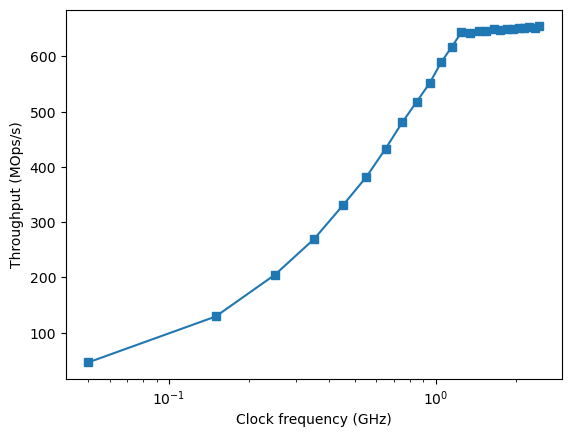

In [338]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('output/sweep_out.txt')

plt.plot(data[0], 50/(data[1] *1E-3), marker = 's')
plt.xlabel('Clock frequency (GHz)')
plt.ylabel('Throughput (MOps/s)')
plt.xscale('log')
plt.savefig('output/example4_frequency_sweep.png', dpi = 300)
plt.show()